# NLP - Final Project#

### BY : SACHIN AGRAWAL AND MARK ###

#### Import all libraries required by program #### 

In [291]:
import re
import glob
import json
import numpy as np
import pandas as pd
import string
from nltk import FreqDist
import gensim
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
pd.options.display.max_colwidth = 200
%matplotlib inline

#### Define constants and global variables ####

In [311]:
metadata_file = 'metadata.csv'
data_file = 'covid_articles_data.csv'
norm_data_file = 'covid_articles_data_norm.csv'
data_root_path = 'CORD-19-research-challenge/**/'
data_columns = ['sha','title','abstract','url']
filter_text = 'covid'
spacy_model = 'en_core_sci_lg'
norm_data_file_lbl='covid_articles_data_norm_lbl.csv'
norm_data_file_lbl_topic='covid_articles_data_norm_lbl_topic.csv'

In [ ]:
metadata_df=None
covid_data_df=None

#### Method to read csv file ####

In [29]:
def read_csv_df(file_name):
    return pd.read_csv(file_name)

### Method to load metadata file ###

In [30]:
def read_metadata():
    df = read_csv_df(metadata_file)
    df = df[df.sha.notnull()]
    df = df.apply(lambda x: x.astype(str).str.lower())
    df = df[(df['title'].str.contains(filter_text) 
                                | df['abstract'].str.contains(filter_text))]
    df = df[df.sha.notnull()]
    print('Shape of metadata dataframe after applying filters:', df.shape)
    print('Number of unique sha',df.sha.nunique())
    return df

#### Load metadata into dataframe #### 

In [31]:
print('Reading metadata is in progress.')
metadata_df=read_metadata()
print('Reading metadata completed.')

Reading metadata is in progress.
Shape of metadata dataframe after applying filters: (2646, 18)
Number of unique sha 2646
Reading metadata completed.


#### Methods to read json body, get file path and load text data ####

In [32]:
#----------------------------------------------------------------------------------------------------------
#    Title: Loading the Data
#    Author: MaksimEkin
#    Code version: Version 26
#    Availability: https://www.kaggle.com/maksimeren/covid-19-literature-clustering#Loading-the-Data
#----------------------------------------------------------------------------------------------------------

def read_body(file_path):
    body_text = []
    try: 
        with open(file_path) as file:
            content = json.load(file)
            for json_value in content['body_text']:
                body_text.append(json_value['text'])
    except:
        pass
    return '\n'.join(body_text)

def get_file_path(file_name):
    path = None
    try:
        path = glob.glob(f'{data_root_path}' + file_name + '.json', recursive=True)[0]
    except:
        pass
    return path

def read_coviddata(meta_df):
    df = meta_df.loc[:,data_columns]
    df['File_path'] = df['sha'].apply(get_file_path)
    df['body_text'] = df['File_path'].apply(read_body)
    df = df[df.body_text.notnull()]
    print('Shape of dataframe after filtering NaN body_txt records records',df.shape)
    df.drop_duplicates(['abstract', 'body_text'], inplace=True)
    print('Shape of dataframe after filtering duplicate absract and body_txt records records',df.shape)
    df['body_word_count']= df['body_text'].apply(lambda x: len(x.strip().split()))
    df['body_unique_words']=df['body_text'].apply(lambda x:len(set(str(x).split())))
    df.to_csv(data_file)
    return df

#### Import articles body text into dataframe and store on disk 

In [33]:
print('Data import is in progress.')
covid_data_df=read_coviddata(metadata_df)
print('Data import completed.')

Data import is in progress.
Shape of dataframe after filtering NaN body_txt records records (2646, 6)
Shape of dataframe after filtering duplicate absract and body_txt records records (2639, 6)
Data import completed.


#### Methods to normalize the text and load into dataframe ##

In [41]:
#----------------------------------------------------------------------------------------------------------
#    Title: Data Pre-processing
#    Author: MaksimEkin
#    Code version: Version 26
#    Availability: https://www.kaggle.com/maksimeren/covid-19-literature-clustering#Data-Pre-processing
#----------------------------------------------------------------------------------------------------------
#    Title: Data Preprocess
#    Author: Aleksei Iancheruk
#    Code version: Version 24
#    Availability: https://www.kaggle.com/alekseiiancheruk/assystem-covid-must-die-risk-factors-analysis/notebook#3.3-Data-Preprocess
#----------------------------------------------------------------------------------------------------------

def text_normalizer(document):
    document = str(document)
    nlp = spacy.load(spacy_model,disable=['tagger', 'ner'])
    stop_words_punch=stopwords.words('english') + list(string.punctuation) + list(spacy.lang.en.stop_words.STOP_WORDS)
    tokens = nlp(document)
    tokens = [
        token.lemma_.lower().strip() for token in tokens if 
        token.lemma_ != "-PRON-"
        and not token.is_punct
        and not token.is_digit
        and not token.like_num
        and not token.like_url
        and not token.like_email
        and token.lemma_.lower() not in stop_words_punch
        and token.text.lower() not in stop_words_punch
        ]
    document = " ".join([i for i in tokens])
    return document

def clean_data(df):
    df['cleaned_body_text'] = df['body_text'].apply(text_normalizer)
    df.to_csv(norm_data_file)
    df['cleaned_body_words']= df['cleaned_body_text'].apply(lambda x: len(x.strip().split()))
    df['cleaned_body_unique_words']=df['cleaned_body_text'].apply(lambda x:len(set(str(x).split())))
    df = df[df['cleaned_body_words']!=0]
    print('Shape of dataframe after removing empty body text:',df.shape)
    df.to_csv(norm_data_file)
    return df

In [42]:
covid_data_df = read_csv_df(data_file)
print('Data normalization is in progress.')
covid_data_df = clean_data(covid_data_df)
print('Data normalization completed.')

Data normalization is in progress.
Shape of dataframe after removing empty body text: (2639, 12)
Data normalization completed.


#### Reload the normalized data file into dataframe and observe data #### 

In [69]:
covid_data_df = read_csv_df(norm_data_file)
covid_data_df = covid_data_df.dropna(subset = ['cleaned_body_text'])
print('Shape of covid dataframe after deleting NaN data.',covid_data_df.shape)
def word_frequency(text,top=20):
    text = str(text)
    words = text.split()
    freqdist = FreqDist(words)
    return freqdist.most_common(top)
print('Look at cleaned data with top 20 words.',end='\n\n')
covid_data_df['most_freq_words'] = covid_data_df['cleaned_body_text'].apply(word_frequency)
covid_data_df[['cleaned_body_text','most_freq_words']].head(10)

Shape of covid dataframe after deleting NaN data. (2590, 13)
Look at cleaned data with top 20 words.



,cleaned_body_text,most_freq_words
0,ingwindow:4:20 minlen:40 new genome sequence obtain map read reference sars-cov-2 genome bwa-mem 0.7.5a-r405 default parameter generate consensus sequence addition assembly produce megahit de novo...,"[(sequence, 23), (genome, 9), (reference, 8), (mutation, 8), (sars-cov-2, 7), (codon, 6), (genbank, 5), (accession, 5), (read, 4), (gisaid, 4), (numb, 4), (isolate, 4), (silent, 4), (map, 3), (con..."
1,european region covid-19 surveillance implement january detail european case february european country report case case study link cluster germany france infect china median case age year male lat...,"[(case, 98), (report, 32), (country, 15), (day, 15), (european, 14), (cluster, 14), (transmission, 13), (europe, 13), (symptom, 13), (china, 12), (infection, 12), (covid-19, 11), (include, 11), (t..."
2,zhenjian current outbreak coronavirus disease covid-19 prompt world health organization declare public health emergency international concern january february covid-19 spread china nearly confirm ...,"[(case, 17), (outbreak, 15), (isolation, 14), (trace, 13), (control, 13), (contact, 12), (model, 11), (covid-19, 9), (china, 9), (transmission, 6), (parameter, 6), (confirm, 5), (effective, 5), (s..."
3,coronavirus disease covid- know severe acute respiratory syndrome coronavirus sars-cov-2 novel coronavirus 2019-ncov identify december wuhan city central china end december covid-19 begin spread r...,"[(sleep, 51), (staff, 46), (medical, 44), (support, 38), (quality, 37), (social, 37), (score, 37), (anxiety, 32), (stress, 32), (study, 29), (self-efficacy, 28), (work, 17), (increase, 16), (covid..."
4,december novel coronavirus covid-19 outbroke wuhan hubei province begin spread rapidly case confirm death china italy iran korea japan united states country report nearly case covid-19 patient ini...,"[(cancer, 20), (covid-19, 13), (patient, 12), (therapy, 11), (treatment, 8), (integrative, 7), (symptom, 5), (chm, 5), (clinical, 4), (case, 3), (epidemic, 3), (especially, 3), (history, 3), (high..."
5,mei fong liew wen ting siow ying wei yau kay choong dear editor covid-19 officially label pandemic global burden disease significant continue rise virus high humanto-human transmissibility airbor...,"[(patient, 10), (covid-19, 9), (transport, 9), (hospital, 5), (staff, 5), (case, 5), (spread, 5), (ward, 4), (require, 4), (ppe, 4), (ambulance, 4), (applicable, 4), (intensive, 3), (care, 3), (un..."
6,coronavirus belong family virus cause symptom pneumonia fever breathe difficulty lung infection virus common animal worldwide case know affect human world health organization term novel coronaviru...,"[(covid-19, 33), (research, 29), (china, 24), (study, 24), (report, 21), (control, 21), (coronavirus, 20), (health, 20), (prevention, 20), (january, 19), (article, 19), (case, 18), (include, 17), ..."
7,cluster patient novel coronavirus pneumonia ncp identify wuhan december soon virus spread tremendous rate sweep china country region world emerge rapidly evolve situation threaten health mankind r...,"[(patient, 26), (ncp, 13), (jiangsu, 11), (early, 11), (rate, 7), (province, 7), (treatment, 7), (critically, 6), (ill, 6), (critical, 6), (screen, 6), (case, 5), (disease, 5), (care, 5), (medical..."
8,international community witness emergence novel coronavirus-associated respiratory disease include severe acute respiratory syndrome sars middle east respiratory syndrome mers ebola emerge western...,"[(travel, 14), (patient, 12), (health, 11), (disease, 9), (sars, 9), (infection, 9), (respiratory, 8), (care, 8), (measure, 7), (mers, 6), (emerge, 6), (covid-19, 6), (case, 6), (vital, 6), (histo..."
9,recent outbreak coronavirus disease covid-19 cause new zoonotic coronary virus sars-cov-2 great threat public health february report person infect sars-cov-2 china covid-19 cause sars-cov-2 infect...,"[(severe, 17), (p, 13), (host, 11), (risk, 11), (covid-19, 10), (score, 10), (patient, 8), (case, 8), (admission, 7), (vs., 7),

#### Get top 100 word from the cleaned body text for all documents

In [72]:
print(word_frequency(covid_data_df['cleaned_body_text'].values,100))

[('case', 123), ('covid-19', 46), ('report', 39), ('china', 30), ('country', 28), ('sars-cov-2', 25), ('sequence', 24), ('africa', 24), ('disease', 22), ('transmission', 21), ('outbreak', 21), ('contact', 20), ('day', 20), ('symptom', 19), ('control', 18), ('isolation', 18), ('infection', 18), ('include', 17), ('test', 16), ('february', 15), ('trace', 15), ('cluster', 14), ('health', 14), ('risk', 14), ('european', 13), ('study', 13), ('detect', 13), ('europe', 13), ('model', 13), ('numb', 12), ('surveillance', 12), ('detection', 12), ('spread', 12), ('confirm', 12), ('result', 11), ('clinical', 11), ('strategy', 11), ('region', 10), ('france', 10), ('respiratory', 10), ('area', 10), ('positive', 10), ('capacity', 10), ('need', 10), ('genome', 9), ('reference', 9), ('high', 9), ('isolate', 9), ('identify', 9), ('coronavirus', 9), ('travel', 9), ('hospitalise', 9), ('fever', 9), ('patient', 9), ('nucleic', 9), ('acid', 9), ('parameter', 8), ('potential', 8), ('datum', 8), ('additional',

#### Perform TF-IDF on normalized data ####

In [76]:
def tfidf_vector(text):
    vectorizer = TfidfVectorizer(max_features=2**12,norm='l2',
                                use_idf=True, smooth_idf=True)
    X = vectorizer.fit_transform(text)
    print('Vectorizer shape:',X.shape)
    X_array = X.toarray()
    return X_array

X_array=tfidf_vector(covid_data_df['cleaned_body_text'].values)

Vectorizer shape: (2590, 4096)


#### Perform vector reduction using PCA algorithm

In [82]:
%%time
def reduce_vector(X):
    pca = PCA(n_components=0.95, random_state=15)
    X_reduced= pca.fit_transform(X)
    print('Shape after reducing vecotor shape using PCA',X_reduced.shape)
    return X_reduced

X_reduced = reduce_vector(X_array)

Shape after reducing vecotor shape using PCA (2590, 1377)
CPU times: user 1min 18s, sys: 2.64 s, total: 1min 20s
Wall time: 13.6 s


#### Identify optimal number of clusters for k-mean algorithm using silhouette score method

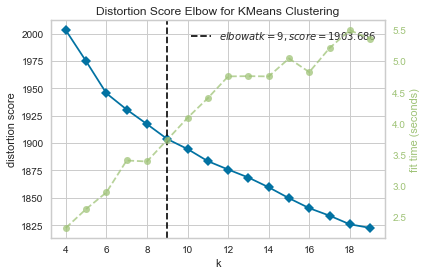

The optimal value of k is: 9
The silhouette score corresponding to the optimal value of k is: 1903.686001779874
CPU times: user 6min 41s, sys: 3.4 s, total: 6min 45s
Wall time: 1min 7s


In [87]:
%%time
def optimal_k(X):
    kmeans_elbow_model = KMeans()
    elbow_visualizer = KElbowVisualizer(kmeans_elbow_model, k=(4,20))
    elbow_visualizer.fit(X)
    elbow_visualizer.show()
    print('The optimal value of k is:',elbow_visualizer.elbow_value_)
    print('The silhouette score corresponding to the optimal value of k is:',elbow_visualizer.elbow_score_)
    return elbow_visualizer.elbow_value_

K = optimal_k(X_reduced)

#### Train k-means model to predict cluster lables for the document text

In [108]:
%%time
def kMeans(X,k):
    model = KMeans(n_clusters=k, random_state=15)
    labels = model.fit_predict(X)
    return labels
labels = kMeans(X_reduced,K)
covid_data_df['y_labels']= labels
covid_data_df.to_csv(norm_data_file_lbl)

CPU times: user 26.5 s, sys: 278 ms, total: 26.8 s
Wall time: 5.34 s


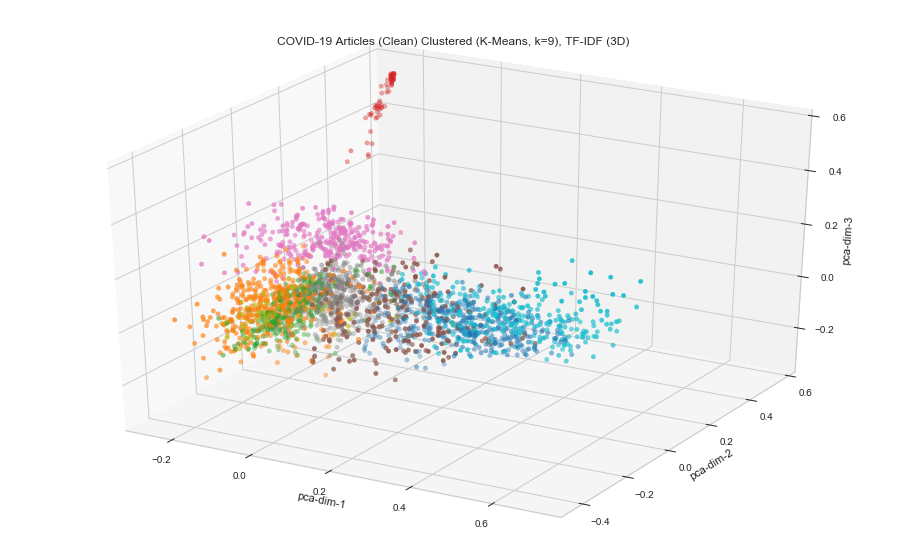

In [109]:
def plot_clusters(X,K,y):
    pca_plot_model = PCA(n_components=3)
    pca_plot = pca_plot_model.fit_transform(X)
    ax = plt.figure(figsize=(16,10)).gca(projection='3d')
    ax.scatter(
        xs=pca_plot[:,0], 
        ys=pca_plot[:,1], 
        zs=pca_plot[:,2], 
        c=y, 
        cmap='tab10'
    )
    ax.set_xlabel('pca-dim-1')
    ax.set_ylabel('pca-dim-2')
    ax.set_zlabel('pca-dim-3')
    plt.title("COVID-19 Articles (Clean) Clustered (K-Means, k="+str(K)+"), TF-IDF (3D)")
    plt.show()
    
plot_clusters(X_reduced,K,labels)

#### Topic modeling for documents in each cluser using gensim
#### Compare LDA model performance using BOW vs TF-IDF

In [465]:
%%time
#----------------------------------------------------------------------------------------------------------
#    Title: Topic Modeling
#    Author: Dipanjan Sarkar
#    Date: 2019
#    Code version: N/A
#    Availability: https://github.com/Apress/text-analytics-w-python-2e
#----------------------------------------------------------------------------------------------------------
covid_data_df = read_csv_df(norm_data_file_lbl)

def bow_vs_tfidf(K):
    number_of_topics = 20
    columns=['cluster','doc_count','bow_coherence','tfidf_coherence','bow_perplexity','tfidf_perplexity']
    df = pd.DataFrame(columns=columns)
    for i in range(K):
        corpuses = covid_data_df.loc[covid_data_df.y_labels==i,'cleaned_body_text'].values
        norm_corpuses = [corpus.split() for corpus in corpuses]
        bigram = gensim.models.Phrases(norm_corpuses, min_count=20, threshold=20,delimiter=b'_')
        bigram_model = gensim.models.phrases.Phraser(bigram)
        norm_corpus_bigrams = [bigram_model[doc] for doc in norm_corpuses]
        dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
        dictionary.filter_extremes(no_below=20, no_above=0.6)
        bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
        tfidf = gensim.models.TfidfModel(bow_corpus)
        corpus_tfidf = tfidf[bow_corpus]
        
        bow_lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary,
                                            chunksize=len(bow_corpus), alpha='auto',
                                            eta='auto', random_state=42,
                                            iterations=500, num_topics=number_of_topics,
                                            passes=20, eval_every=None)

        topics_coherences = bow_lda_model.top_topics(bow_corpus, topn=number_of_topics)
        bow_avg_coherence_score = np.mean([item[1] for item in topics_coherences])
        bow_perplexity = bow_lda_model.log_perplexity(bow_corpus)

        tfidf_lda_model = gensim.models.LdaModel(corpus=corpus_tfidf, id2word=dictionary,
                                            chunksize=len(corpus_tfidf), alpha='auto',
                                            eta='auto', random_state=42,
                                            iterations=500, num_topics=number_of_topics,
                                            passes=20, eval_every=None)
        
        topics_coherences = tfidf_lda_model.top_topics(corpus_tfidf, topn=number_of_topics)
        tfidf_avg_coherence_score = np.mean([item[1] for item in topics_coherences])
        tfidf_perplexity = bow_lda_model.log_perplexity(corpus_tfidf)
        row = [i,len(bow_corpus),bow_avg_coherence_score,tfidf_avg_coherence_score,bow_perplexity,tfidf_perplexity]
        df = df.append(pd.Series(row,index=df.columns),ignore_index=True)
    return df

bow_vs_tfidf(K)

CPU times: user 9min 17s, sys: 3.23 s, total: 9min 20s
Wall time: 5min 25s


,cluster,doc_count,bow_coherence,tfidf_coherence,bow_perplexity,tfidf_perplexity
0,0.0,394.0,-0.919773,-2.225242,-6.894749,-20.269760
1,1.0,444.0,-0.872377,-2.071708,-7.064835,-17.520554
2,2.0,342.0,-0.896109,-1.779367,-6.805743,-17.929754
3,3.0,70.0,-0.818670,-2.966305,-4.167399,-9.039205
4,4.0,232.0,-1.009099,-1.743263,-6.691679,-19.779699
5,5.0,301.0,-0.997639,-1.764081,-6.777574,-21.542356
6,6.0,431.0,-1.059376,-2.508637,-6.800717,-17.481860
7,7.0,84.0,-0.703130,-0.840133,-5.761933,-18.414931
8,8.0,292.0,-1.051853,-2.049427,-6.654488,-19.843078


In [467]:
%%time
#----------------------------------------------------------------------------------------------------------
#    Title: Topic Modeling
#    Author: Dipanjan Sarkar
#    Date: 2019
#    Code version: N/A
#    Availability: https://github.com/Apress/text-analytics-w-python-2e
#----------------------------------------------------------------------------------------------------------

covid_data_df = read_csv_df(norm_data_file_lbl)
covid_data_df['dominant_topic'] = np.nan
covid_data_df['contribution'] = np.nan
covid_data_df['topic_desc'] = np.nan

def cluster_topics(K):
    lda_model = None
    bigram_model = None
    dictionary = None
    df_final = pd.DataFrame(columns=covid_data_df.columns.values)
    number_of_topics = 20
    for i in range(K):
        df = pd.DataFrame(columns=covid_data_df.columns.values)
        df = df.append(covid_data_df[covid_data_df.y_labels==i])
        corpuses = covid_data_df.loc[covid_data_df.y_labels==i,'cleaned_body_text'].values
        norm_corpuses = [corpus.split() for corpus in corpuses]
        bigram = gensim.models.Phrases(norm_corpuses, min_count=20, threshold=20,delimiter=b'_')
        bigram_model = gensim.models.phrases.Phraser(bigram)
        norm_corpus_bigrams = [bigram_model[doc] for doc in norm_corpuses]
        dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
        dictionary.filter_extremes(no_below=20, no_above=0.6)
        bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]

        lda_model = gensim.models.LdaModel( corpus=bow_corpus, id2word=dictionary,
                                            chunksize=len(bow_corpus), alpha='auto',
                                            eta='auto', random_state=42,
                                            iterations=500, num_topics=number_of_topics,
                                            passes=20, eval_every=None)


        topics = [[(term, round(wt, 3))
            for term, wt in lda_model.show_topic(n, topn=number_of_topics)]
                for n in range(0, lda_model.num_topics)]

        topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics],
                columns = ['Terms per Topic'],
                index=['Topic'+str(t) for t in range(1, lda_model.num_topics+1)])

        tm_results = lda_model[bow_corpus]
        corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

        df['dominant_topic'] = [item[0]+1 for item in corpus_topics]
        df['contribution']=[round(item[1]*100, 2) for item in corpus_topics]
        df['topic_desc']=[topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
        df_final = df_final.append(df)
    return df_final,lda_model,bigram_model,dictionary

print('Topic assignment is in progress for documents..')
df,lda_model,bigram_model,dictionary=cluster_topics(K)
covid_data_df['dominant_topic']=df['dominant_topic']
covid_data_df['contribution']=df['contribution']
covid_data_df['topic_desc']=df['topic_desc']

covid_data_df.to_csv(norm_data_file_lbl_topic)
lda_model.save('lda_model')
bigram_model.save('bigram_model')
dictionary.save('dictionary')
print('All documents assigned with topics..')

Topic assignment is in progress for documents..
All documents assigned with topics..
CPU times: user 5min 52s, sys: 1.27 s, total: 5min 54s
Wall time: 3min 37s


#### The most scoring contribution percentage document for each topic

In [468]:
covid_data_df[['title','dominant_topic','contribution','topic_desc']].groupby('dominant_topic').apply(lambda topic_set:(topic_set.sort_values(by=['contribution'],ascending=False).iloc[0]))

,title,dominant_topic,contribution,topic_desc
dominant_topic,,,,
1,a model for supply-chain decisions for resource sharing with an application to ventilator allocation to combat covid-19,1,99.96,"ventilator, n, patient, temperature, state, et_al., curve, demand, ∈, pressure, perpetuity_peer-reviewed, region, correlation, type, method, peak, fatality_rate, optimal, mitigation, cumulative"
2,pressure-regulated ventilator splitting (prevents): a covid-19 response paradigm from yale university,2,99.97,"pressure, ventilator, valve, lung, circuit, ventilation, flow, set, oxygen, system, monitor, compliance, figure, change, respiratory, test, volume, control, deliver, connect"
3,coronavirus: la emergencia geriátrica de 2020. documento conjunto de la sección de cardiología geriátrica de la sociedad española de cardiología y la sociedad española de geriatría y gerontología,3,99.97,"el, los, con, del, por, pacientes, para, las, una, como, al, más, su, casos, este, caso, paciente, lo, enfermedad, han"
4,molecular mechanism of action of repurposed drugs and traditional chinese medicine used for the treatment of patients infected with covid-19: a systematic review,4,99.96,"treatment, et_al., viral, sars-cov-2, drug, cell, community, copyright_holder, level, influenza, symptom, reduce, severe, pandemic, system, pneumonia, treat, human, cc-by-nd_international, release"
5,triage of scarce critical care resources in covid-19: an implementation guide for regional allocation an expert panel report of the task force for mass critical care and the american college of chest physicians,5,99.97,"resource, critical_care, triage, system, icu, intensive_care, capacity, surge, staff, plan, crisis, decision, datum, bed, mortality, critically_ill, ventilator, level, support, protocol"
6,a mechanistic population balance model to evaluate the impact of interventions on infectious disease outbreaks: case for covid19,6,99.97,"mask, isolation, r0, scenario, intervention, impact, et_al., effective, growth_rate, protection, fatality, social, β, suggest, effectiveness, reduction, symptomatic, spain, infectious, resource"
7,propagation analysis and prediction of the covid-19,7,99.94,"february, patient, trend, peak, italy, pandemic, curve, south_korea, situation, prediction, reach, calculate, end, actual, world, phase, holder_preprint, january, official, simulation"
8,predicting the impacts of epidemic outbreaks on global supply chains: a simulation-based analysis on the coronavirus outbreak (covid-19/sars-cov-2) case,8,99.97,"et_al., epidemic, day, datum, disruption, china, model, decrease, temperature, result, city, observe, fig., impact, study, different, scenario, air, region, effect"
9,global profiling of sars-cov-2 specific igg/ igm responses of convalescents using a proteome microarray,9,99.96,"n, serum, antibody, igg, fig., et_al., author/funder_grant, medrxiv_license, display_preprint, s1, day, response, sample, specific, transmission, complement, signal, age, rate, correlation"


#### Distribution of topics across documents

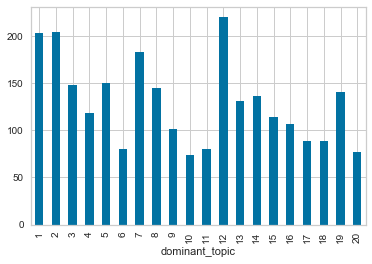

In [469]:
#----------------------------------------------------------------------------------------------------------
#    Title: Data exploration with Topic Modelling
#    Author: Aleksei Iancheruk
#    Code version: Version 24
#    Availability: #https://www.kaggle.com/alekseiiancheruk/assystem-covid-must-die-risk-factors-analysis/notebook#3.4-Data-exploration-with-Topic-Modelling
#----------------------------------------------------------------------------------------------------------

topic_df = pd.DataFrame()
topic_df = covid_data_df.groupby(['dominant_topic'])['title'].count()
topic_df.plot.bar(x='dominant_topic', y='Count')

#### Predict the topics from unseen document and identify articles

In [481]:
#----------------------------------------------------------------------------------------------------------
#    Title: Data exploration with Topic Modelling
#    Author: Aleksei Iancheruk
#    Code version: Version 24
#    Availability: #https://www.kaggle.com/alekseiiancheruk/assystem-covid-must-die-risk-factors-analysis/notebook#3.4-Data-exploration-with-Topic-Modelling
#----------------------------------------------------------------------------------------------------------

lda_model =  gensim.models.LdaModel.load('lda_model')
bigram_model = gensim.models.phrases.Phraser.load('bigram_model')
dictionary = gensim.corpora.Dictionary.load('dictionary')
covid_data_df = read_csv_df(norm_data_file_lbl_topic)
def predict_topic(text):
    norm_text = text_normalizer(text)
    norm_text_bigrams = bigram_model[norm_text.split()]
    bow_corpus = dictionary.doc2bow(norm_text_bigrams)
    lda_topics = sorted(lda_model.get_document_topics(bow_corpus), key=lambda x: x[1], reverse=True)
    rows = []
    for i, score in lda_topics:
        if score > 0.1:
            words, _ = zip(*lda_model.show_topic(i))
            rows.append([text,f'Topic_{i+1}', score,', '.join(words)])
            break
    return pd.DataFrame(rows, columns=['text','Topic', 'Score', 'Words'])

#### Find the predicted topics and high dominant topic using lda model 

In [482]:
%%time
pred_topic_df =pd.DataFrame()

text1 = '''
Data on potential risks factors
Smoking, pre-existing pulmonary disease
Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities
Neonates and pregnant women
Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.
'''
pred_topic_df = pred_topic_df.append(predict_topic(text1))

text2 = '''
Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors
'''
pred_topic_df = pred_topic_df.append(predict_topic(text2))

text3 = '''
Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups
'''

pred_topic_df = pred_topic_df.append(predict_topic(text3))

text4 = '''
Susceptibility of populations
'''

pred_topic_df = pred_topic_df.append(predict_topic(text4))

text5 = '''
Public health mitigation measures that could be effective for control
'''

pred_topic_df = pred_topic_df.append(predict_topic(text5))

pred_topic_df

CPU times: user 53.1 s, sys: 2.76 s, total: 55.9 s
Wall time: 56.3 s


,text,Topic,Score,Words
0,"\nData on potential risks factors\nSmoking, pre-existing pulmonary disease\nCo-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities\nNeonates and pregnant women\nSocio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.\n",Topic_12,0.485415,"severe, age, clinical, feature, comorbidity, hospital, risk, respiratory, value, image"
0,"\nTransmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors\n",Topic_8,0.455289,"wuhan, january, symptom_onset, epidemic, period, february, incubation_period, city, early, date"
0,"\nSeverity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups\n",Topic_2,0.664322,"region, age, italy, death, distribution, scenario, city, epidemic, capacity, clinical"
0,\nSusceptibility of populations\n,Topic_11,0.628064,"contact, asymptomatic, assume, intervention, symptomatic, social_distance, proportion, individual, cell, peak"
0,\nPublic health mitigation measures that could be effective for control\n,Topic_1,0.872338,"policy, et_al., effect, reduce, risk, work, state, people, level, control"


#### Get the 2 documents with title for each text

In [483]:
df_docs = pd.DataFrame()
def get_topic_documents(dominant_topic,num=5):
    df = covid_data_df[['title','url']][covid_data_df['dominant_topic']==dominant_topic]
    return df.head(num)

for index, row in pred_topic_df.iterrows():
    dominant_topic = int(row.Topic.split('_')[-1])
    df = get_topic_documents(dominant_topic,2)
    df['text'] = row.text
    df_docs = df_docs.append(df)
    
df_docs

,title,url,text
3,the effects of social support on sleep quality of medical staff treating patients with coronavirus disease 2019 (covid-19) in january and february 2020 in china,https://www.ncbi.nlm.nih.gov/pmc/articles/pmc7075079/,"\nData on potential risks factors\nSmoking, pre-existing pulmonary disease\nCo-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities\nNeonates and pregnant women\nSocio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.\n"
16,knowledge and perceptions of covid-19 among the general public in the united states and the united kingdom: a cross-sectional online survey,https://www.ncbi.nlm.nih.gov/pmc/articles/pmc7086377/,"\nData on potential risks factors\nSmoking, pre-existing pulmonary disease\nCo-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities\nNeonates and pregnant women\nSocio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.\n"
9,host susceptibility to severe covid-19 and establishment of a host risk score: findings of 487 cases outside wuhan,https://www.ncbi.nlm.nih.gov/pmc/articles/pmc7081524/,"\nTransmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors\n"
17,ai-driven tools for coronavirus outbreak: need of active learning and cross-population train/test models on multitudinal/multimodal data,https://www.ncbi.nlm.nih.gov/pmc/articles/pmc7087612/,"\nTransmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors\n"
11,"covid-19: knowns, unknowns, and questions",https://www.ncbi.nlm.nih.gov/pmc/articles/pmc7082143/,"\nSeverity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups\n"
13,responding to the covid-19 pandemic in complex humanitarian crises,https://www.ncbi.nlm.nih.gov/pmc/articles/pmc7085188/,"\nSeverity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups\n"
4,challenges and countermeasures of integrative cancer therapy in the epidemic of covid-19,https://www.ncbi.nlm.nih.gov/pmc/articles/pmc7079301/,\nSusceptibility of populations\n
79,psychological impact of the covid-19 pandemic on health care workers in singapore,https://www.ncbi.nlm.nih.gov/pmc/articles/pmc7143149/,\nSusceptibility of populations\n
37,mental health and psychological intervention amid covid-19 outbreak: perspectives from south korea,https://www.ncbi.nlm.nih.gov/pmc/articles/pmc7105405/,\nPublic health mitigation measures that could be effective for control\n
39,supporting clinicians during the covid-19 pandemic,https://www.ncbi.nlm.nih.gov/pmc/articles/pmc7106065/,\nPublic health mitigation measures that could be effective for control\n
